# 2026 MCM C题 - 与明星共舞
# 探索性数据分析 (EDA)

---

| 项目 | 说明 |
|------|------|
| **数据来源** | COMAP 官方竞赛数据 |
| **目的** | 了解数据结构、分布和缺失模式 |
| **注意** | 本笔记本仅探索数据，不修改原始数据 |

---

## 1. 环境配置

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from cycler import cycler

warnings.filterwarnings('ignore')

# 竞赛风格配置 (基于 publication_styles.py)
COLORS = {
    'primary': '#3C5488',
    'secondary': '#E64B35',
    'tertiary': '#00A087',
    'quaternary': '#F39B7F',
    'fifth': '#4DBBD5',
    'sixth': '#8491B4',
}

SCIENTIFIC_COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['SimHei', 'Arial', 'DejaVu Sans'],
    'axes.unicode_minus': False,
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.prop_cycle': cycler('color', SCIENTIFIC_COLORS),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
})

print('=' * 50)
print('环境配置完成')
print('=' * 50)
print(f'  pandas  : {pd.__version__}')
print(f'  numpy   : {np.__version__}')
print(f'  风格    : 竞赛论文风格')
print('=' * 50)

环境配置完成
  pandas  : 2.3.3
  numpy   : 2.2.6
  风格    : 竞赛论文风格


## 2. 数据加载

In [2]:
DATA_PATH = 'data/2026_MCM_Problem_C_Data.csv'
df = pd.read_csv(DATA_PATH)

print('=' * 50)
print('数据加载摘要')
print('=' * 50)
print(f'  文件路径  : {DATA_PATH}')
print(f'  总行数    : {len(df):,} 名选手')
print(f'  总列数    : {len(df.columns)} 个特征')
print(f'  赛季范围  : 第{df.season.min()}季 - 第{df.season.max()}季')
print(f'  内存占用  : {df.memory_usage(deep=True).sum() / 1024:.1f} KB')
print('=' * 50)

数据加载摘要
  文件路径  : data/2026_MCM_Problem_C_Data.csv
  总行数    : 421 名选手
  总列数    : 53 个特征
  赛季范围  : 第1季 - 第34季
  内存占用  : 324.0 KB


## 3. 数据结构概览

In [3]:
basic_cols = list(df.columns[:9])
score_cols = [c for c in df.columns if 'week' in c and 'judge' in c]

print('=' * 60)
print('列分类')
print('=' * 60)
print('\n[基本信息列] 9列')
print('-' * 50)
for col in basic_cols:
    dtype = str(df[col].dtype)
    nunique = df[col].nunique()
    print(f'  {col:<35} | {dtype:<8} | {nunique:>4} 个唯一值')

print(f'\n[评分列] {len(score_cols)}列')
print('-' * 50)
print(f'  格式: week{{1-11}}_judge{{1-4}}_score')
print(f'  总计: 11周 x 4评委 = 44列')
print('=' * 60)

列分类

[基本信息列] 9列
--------------------------------------------------
  celebrity_name                      | object   |  408 个唯一值
  ballroom_partner                    | object   |   60 个唯一值
  celebrity_industry                  | object   |   26 个唯一值
  celebrity_homestate                 | object   |   45 个唯一值
  celebrity_homecountry/region        | object   |   26 个唯一值
  celebrity_age_during_season         | int64    |   62 个唯一值
  season                              | int64    |   34 个唯一值
  results                             | object   |   17 个唯一值
  placement                           | int64    |   16 个唯一值

[评分列] 44列
--------------------------------------------------
  格式: week{1-11}_judge{1-4}_score
  总计: 11周 x 4评委 = 44列


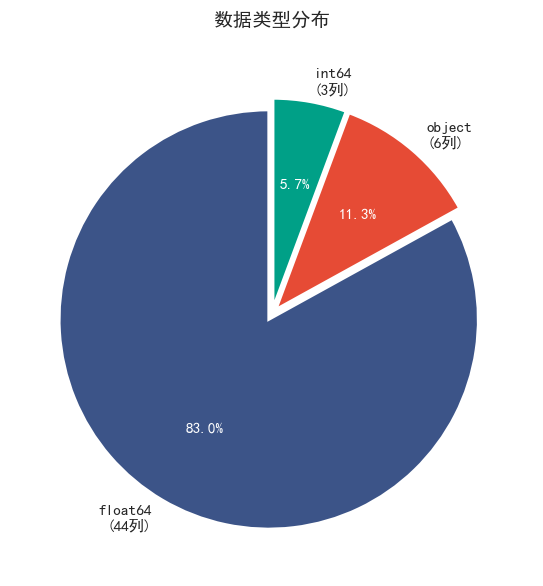


解读:
  - float64: 评分列（每周评委打分）
  - object : 文本列（姓名、类别）
  - int64  : 数值列（赛季、年龄、名次）


In [4]:
# 数据类型分布饼图
fig, ax = plt.subplots(figsize=(8, 6))

dtype_counts = df.dtypes.astype(str).value_counts()
colors_pie = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

wedges, texts, autotexts = ax.pie(
    dtype_counts.values,
    labels=[f'{k}\n({v}列)' for k, v in dtype_counts.items()],
    autopct='%1.1f%%',
    colors=colors_pie[:len(dtype_counts)],
    explode=[0.03] * len(dtype_counts),
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('数据类型分布', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('\n解读:')
print('  - float64: 评分列（每周评委打分）')
print('  - object : 文本列（姓名、类别）')
print('  - int64  : 数值列（赛季、年龄、名次）')

## 4. 缺失值分析

In [5]:
print('=' * 60)
print('缺失值分析 - 基本信息列')
print('=' * 60)
print(f'{"列名":<35} {"缺失数":>8} {"缺失率":>10} {"状态":>8}')
print('-' * 60)
for col in basic_cols:
    null_count = df[col].isnull().sum()
    null_pct = null_count / len(df) * 100
    status = '正常' if null_count == 0 else '警告'
    print(f'{col:<35} {null_count:>8} {null_pct:>9.1f}% {status:>8}')
print('=' * 60)

缺失值分析 - 基本信息列
列名                                       缺失数        缺失率       状态
------------------------------------------------------------
celebrity_name                             0       0.0%       正常
ballroom_partner                           0       0.0%       正常
celebrity_industry                         0       0.0%       正常
celebrity_homestate                       56      13.3%       警告
celebrity_homecountry/region               0       0.0%       正常
celebrity_age_during_season                0       0.0%       正常
season                                     0       0.0%       正常
results                                    0       0.0%       正常
placement                                  0       0.0%       正常


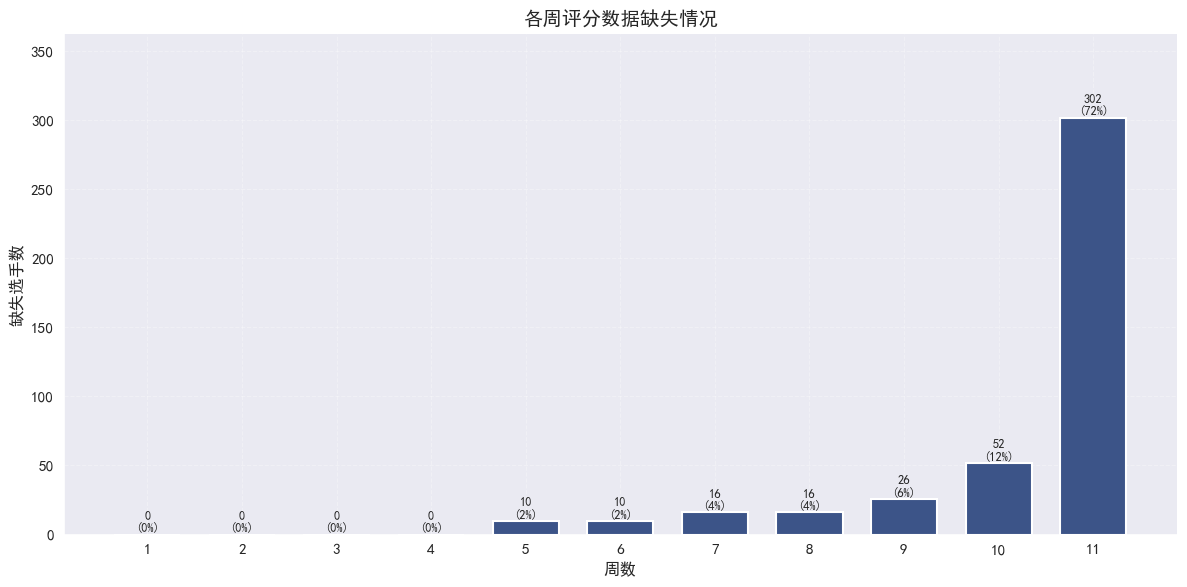


解读: 缺失值随周数增加（选手被淘汰）


In [6]:
# 按周统计评分缺失
week_missing = []
for week in range(1, 12):
    week_cols = [c for c in df.columns if f'week{week}_' in c]
    if week_cols:
        all_na = df[week_cols].isnull().all(axis=1).sum()
        week_missing.append({'周': week, '缺失数': all_na, '缺失率': all_na/len(df)*100})

missing_df = pd.DataFrame(week_missing)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(missing_df['周'], missing_df['缺失数'], 
              color=COLORS['primary'], edgecolor='white', linewidth=1.5, width=0.7)

for bar, pct in zip(bars, missing_df['缺失率']):
    height = bar.get_height()
    ax.annotate(f'{int(height)}\n({pct:.0f}%)',
                xy=(bar.get_x() + bar.get_width()/2, height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('周数', fontsize=12)
ax.set_ylabel('缺失选手数', fontsize=12)
ax.set_title('各周评分数据缺失情况', fontsize=14, fontweight='bold')
ax.set_xticks(missing_df['周'])
ax.set_ylim(0, max(missing_df['缺失数']) * 1.2)
plt.tight_layout()
plt.show()

print('\n解读: 缺失值随周数增加（选手被淘汰）')

## 5. 选手分布分析

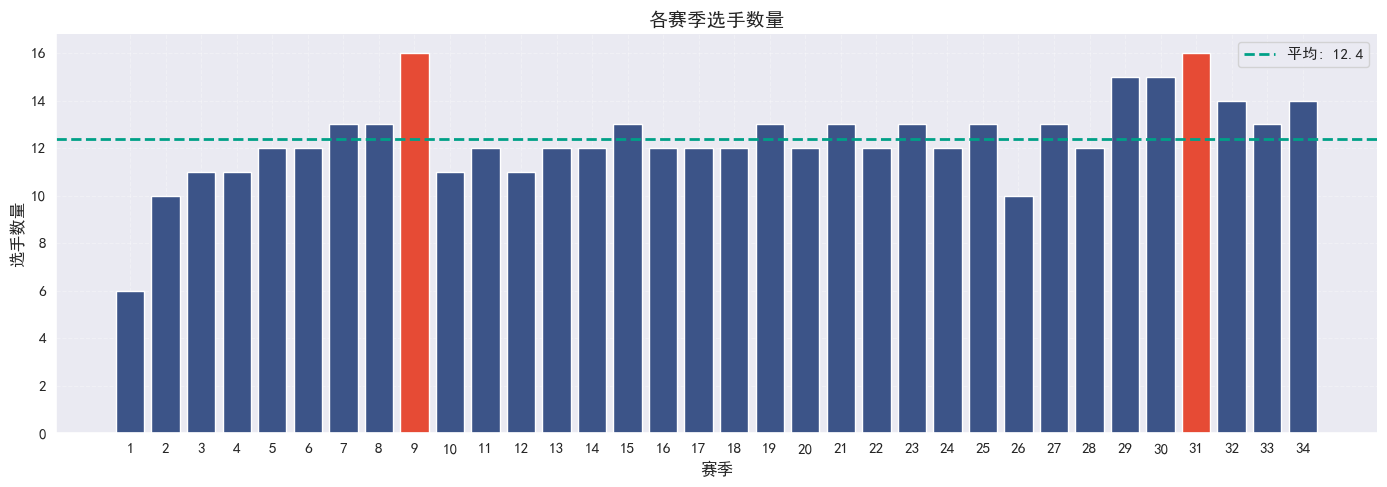

统计: 最少6 | 最多16 | 平均12.4


In [7]:
# 各赛季选手数量
season_counts = df.groupby('season').size()

fig, ax = plt.subplots(figsize=(14, 5))
colors_bar = [COLORS['secondary'] if x == season_counts.max() else COLORS['primary'] 
              for x in season_counts.values]
bars = ax.bar(season_counts.index, season_counts.values, color=colors_bar, 
              edgecolor='white', linewidth=1)
ax.axhline(y=season_counts.mean(), color=COLORS['tertiary'], linestyle='--', 
           linewidth=2, label=f'平均: {season_counts.mean():.1f}')
ax.set_xlabel('赛季', fontsize=12)
ax.set_ylabel('选手数量', fontsize=12)
ax.set_title('各赛季选手数量', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xticks(season_counts.index)
plt.tight_layout()
plt.show()

print(f'统计: 最少{season_counts.min()} | 最多{season_counts.max()} | 平均{season_counts.mean():.1f}')

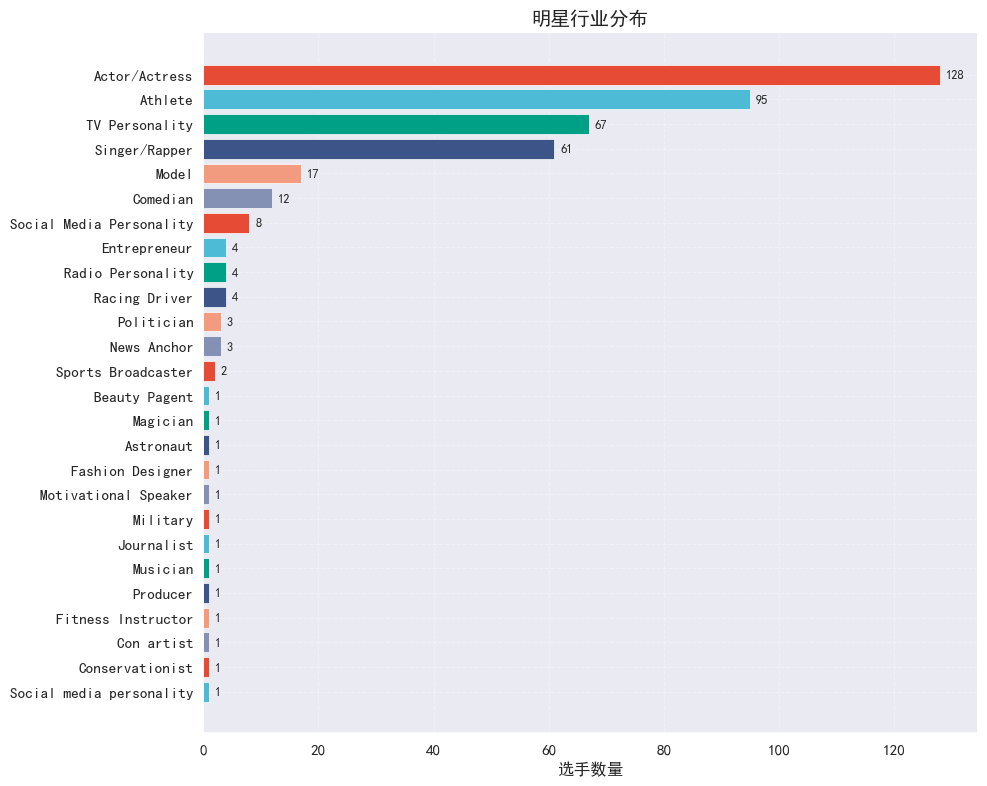

前3行业: ['Actor/Actress', 'Athlete', 'TV Personality']


In [8]:
# 行业分布
industry_counts = df['celebrity_industry'].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
colors_h = [SCIENTIFIC_COLORS[i % len(SCIENTIFIC_COLORS)] for i in range(len(industry_counts))]
bars = ax.barh(range(len(industry_counts)), industry_counts.values, 
               color=colors_h, edgecolor='white', linewidth=0.5)
ax.set_yticks(range(len(industry_counts)))
ax.set_yticklabels(industry_counts.index)
ax.invert_yaxis()

for bar, val in zip(bars, industry_counts.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, str(val), 
            va='center', fontsize=9, fontweight='bold')

ax.set_xlabel('选手数量', fontsize=12)
ax.set_title('明星行业分布', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'前3行业: {list(industry_counts.head(3).index)}')

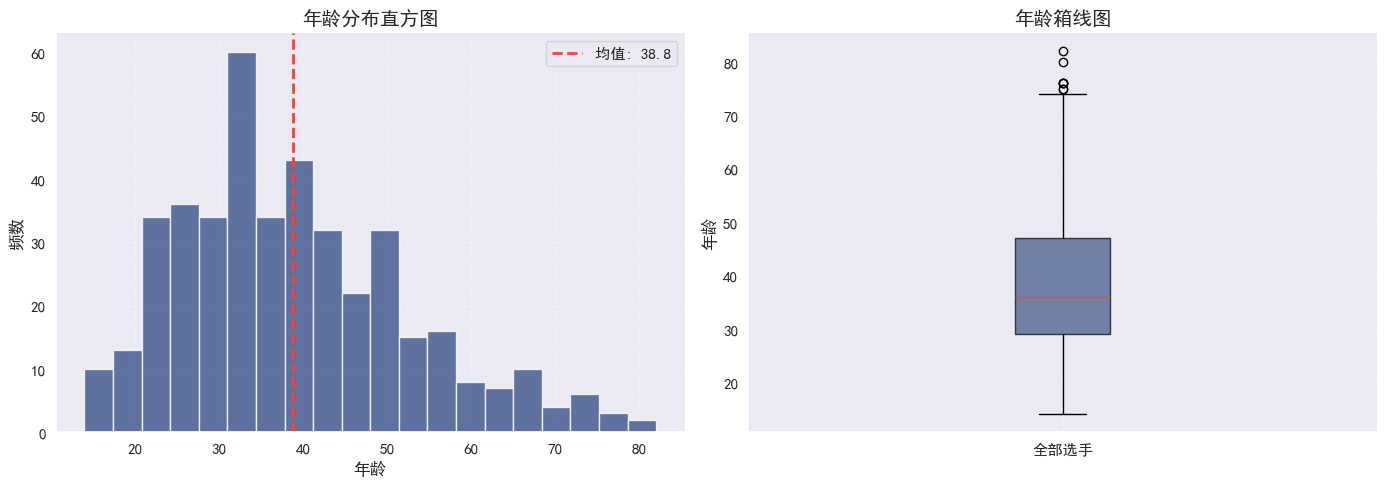

年龄: 最小14 | 最大82 | 均值38.8


In [9]:
# 年龄分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['celebrity_age_during_season'], bins=20, color=COLORS['primary'], 
             edgecolor='white', alpha=0.8)
axes[0].axvline(df['celebrity_age_during_season'].mean(), color=COLORS['secondary'], 
                linestyle='--', linewidth=2, label=f'均值: {df["celebrity_age_during_season"].mean():.1f}')
axes[0].set_xlabel('年龄', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('年龄分布直方图', fontsize=14, fontweight='bold')
axes[0].legend()

bp = axes[1].boxplot(df['celebrity_age_during_season'], patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor(COLORS['primary'])
bp['boxes'][0].set_alpha(0.7)
bp['medians'][0].set_color(COLORS['secondary'])
axes[1].set_ylabel('年龄', fontsize=12)
axes[1].set_title('年龄箱线图', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['全部选手'])
plt.tight_layout()
plt.show()

age_stats = df['celebrity_age_during_season'].describe()
print(f'年龄: 最小{age_stats["min"]:.0f} | 最大{age_stats["max"]:.0f} | 均值{age_stats["mean"]:.1f}')

## 6. 比赛结果分析

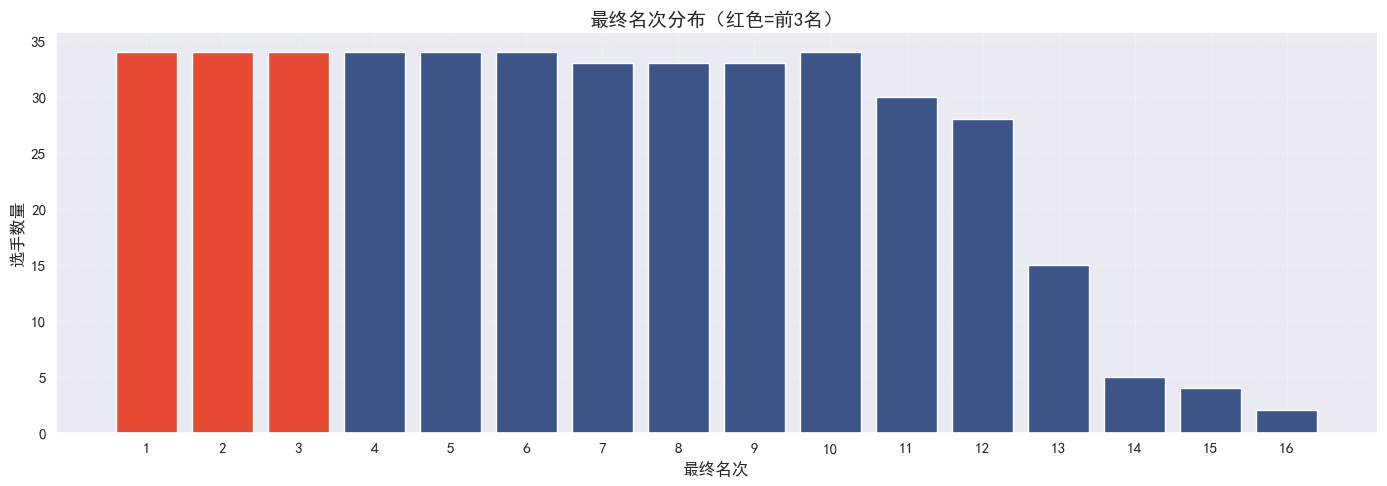

名次统计: 共16个名次 | 冠军数: 34


In [10]:
# 最终名次分布
placement_counts = df['placement'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 5))
colors_p = [COLORS['secondary'] if p <= 3 else COLORS['primary'] for p in placement_counts.index]
bars = ax.bar(placement_counts.index, placement_counts.values, color=colors_p, 
              edgecolor='white', linewidth=1)
ax.set_xlabel('最终名次', fontsize=12)
ax.set_ylabel('选手数量', fontsize=12)
ax.set_title('最终名次分布（红色=前3名）', fontsize=14, fontweight='bold')
ax.set_xticks(placement_counts.index)
plt.tight_layout()
plt.show()

print(f'名次统计: 共{len(placement_counts)}个名次 | 冠军数: {placement_counts.get(1, 0)}')

In [11]:
# 淘汰结果分布
results_counts = df['results'].value_counts()

print('=' * 55)
print('淘汰结果分布')
print('=' * 55)
print(f'{"结果":<25} {"数量":>8} {"占比":>10}')
print('-' * 45)
for result, count in results_counts.head(10).items():
    pct = count / len(df) * 100
    print(f'{result[:25]:<25} {count:>8} {pct:>9.1f}%')
print('=' * 55)

淘汰结果分布
结果                              数量         占比
---------------------------------------------
Eliminated Week 2               40       9.5%
Eliminated Week 8               36       8.6%
Eliminated Week 7               36       8.6%
Eliminated Week 4               35       8.3%
2nd Place                       34       8.1%
3rd Place                       34       8.1%
1st Place                       34       8.1%
Eliminated Week 3               33       7.8%
Eliminated Week 9               32       7.6%
Eliminated Week 6               31       7.4%


## 7. 评分数据分析

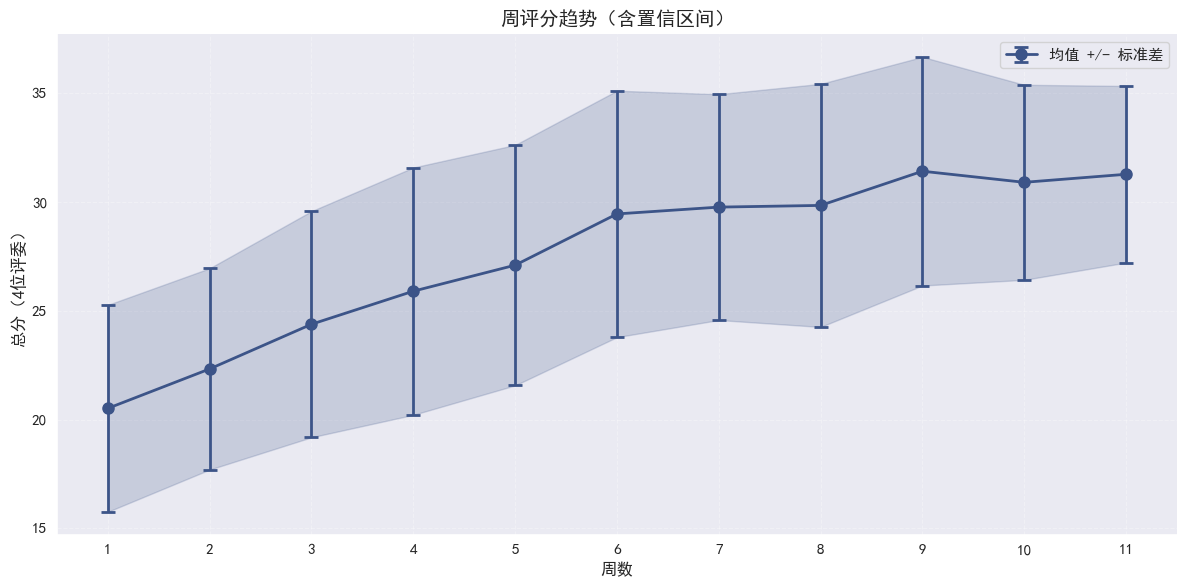

解读: 评分随比赛进行逐渐提高（留下的选手表现更好）


In [12]:
# 周评分趋势
weekly_stats = []
for week in range(1, 12):
    week_cols = [c for c in df.columns if f'week{week}_' in c]
    if week_cols:
        total = df[week_cols].sum(axis=1)
        valid = total[total > 0]
        if len(valid) > 0:
            weekly_stats.append({'周': week, '均值': valid.mean(), '标准差': valid.std(), 'N': len(valid)})

stats_df = pd.DataFrame(weekly_stats)

fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(stats_df['周'], stats_df['均值'], yerr=stats_df['标准差'],
            fmt='o-', color=COLORS['primary'], capsize=5, capthick=2,
            markersize=8, linewidth=2, label='均值 +/- 标准差')
ax.fill_between(stats_df['周'], stats_df['均值'] - stats_df['标准差'],
                stats_df['均值'] + stats_df['标准差'], alpha=0.2, color=COLORS['primary'])
ax.set_xlabel('周数', fontsize=12)
ax.set_ylabel('总分（4位评委）', fontsize=12)
ax.set_title('周评分趋势（含置信区间）', fontsize=14, fontweight='bold')
ax.set_xticks(stats_df['周'])
ax.legend()
plt.tight_layout()
plt.show()

print('解读: 评分随比赛进行逐渐提高（留下的选手表现更好）')

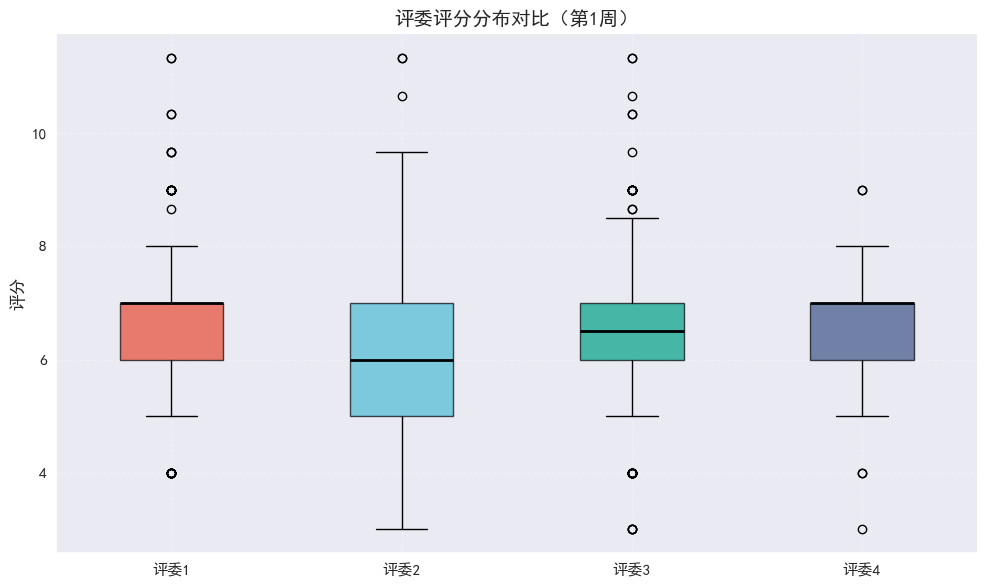

解读: 对比各评委的评分风格（严格/宽松）


In [13]:
# 评委评分对比（第1周）
week1_cols = [c for c in df.columns if 'week1_' in c]
judge_data = []
for i, col in enumerate(sorted(week1_cols), 1):
    valid = df[col][df[col] > 0]
    judge_data.append(valid.values)

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(judge_data, patch_artist=True, labels=[f'评委{i}' for i in range(1, 5)])
for i, (patch, color) in enumerate(zip(bp['boxes'], SCIENTIFIC_COLORS[:4])):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)
ax.set_ylabel('评分', fontsize=12)
ax.set_title('评委评分分布对比（第1周）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('解读: 对比各评委的评分风格（严格/宽松）')

## 8. 相关性分析

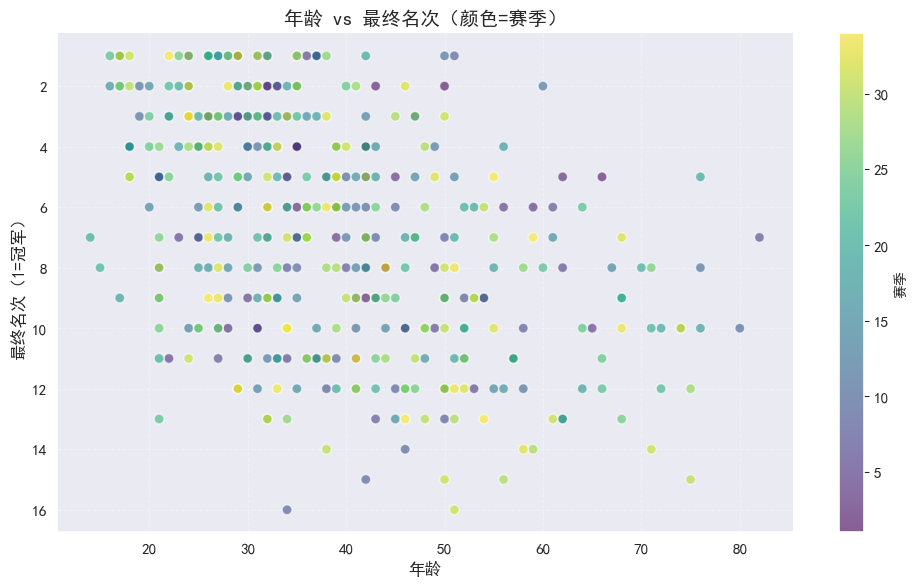

相关系数（年龄 vs 名次）: 0.433（接近0表示弱相关）


In [14]:
# 年龄 vs 名次
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df['celebrity_age_during_season'], df['placement'],
                     c=df['season'], cmap='viridis', alpha=0.6, s=50, edgecolor='white')
ax.set_xlabel('年龄', fontsize=12)
ax.set_ylabel('最终名次（1=冠军）', fontsize=12)
ax.set_title('年龄 vs 最终名次（颜色=赛季）', fontsize=14, fontweight='bold')
ax.invert_yaxis()
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('赛季', fontsize=10)
plt.tight_layout()
plt.show()

corr = df['celebrity_age_during_season'].corr(df['placement'])
print(f'相关系数（年龄 vs 名次）: {corr:.3f}（接近0表示弱相关）')

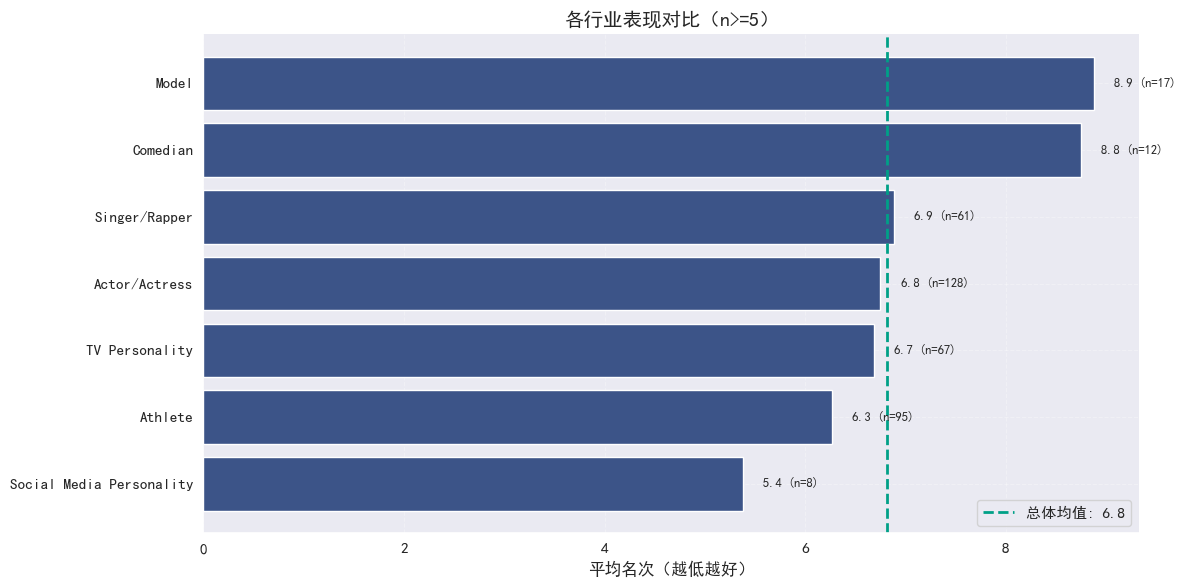

表现最好的行业: Social Media Personality


In [15]:
# 行业 vs 平均名次
industry_perf = df.groupby('celebrity_industry')['placement'].agg(['mean', 'count'])
industry_perf = industry_perf[industry_perf['count'] >= 5].sort_values('mean')

fig, ax = plt.subplots(figsize=(12, 6))
colors_ind = [COLORS['secondary'] if m <= 5 else COLORS['primary'] for m in industry_perf['mean']]
bars = ax.barh(range(len(industry_perf)), industry_perf['mean'], color=colors_ind, edgecolor='white')
ax.set_yticks(range(len(industry_perf)))
ax.set_yticklabels(industry_perf.index)
ax.axvline(x=df['placement'].mean(), color=COLORS['tertiary'], linestyle='--',
           linewidth=2, label=f'总体均值: {df["placement"].mean():.1f}')

for bar, (_, row) in zip(bars, industry_perf.iterrows()):
    ax.text(row['mean'] + 0.2, bar.get_y() + bar.get_height()/2,
            f'{row["mean"]:.1f} (n={int(row["count"])})', va='center', fontsize=9)

ax.set_xlabel('平均名次（越低越好）', fontsize=12)
ax.set_title('各行业表现对比（n>=5）', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'表现最好的行业: {industry_perf.index[0]}')

## 9. EDA 总结

In [16]:
print('=' * 60)
print('EDA 总结报告')
print('=' * 60)

print('\n[数据概览]')
print(f'  总选手数  : {len(df):,}')
print(f'  总赛季数  : {df.season.nunique()} (第{df.season.min()}-{df.season.max()}季)')
print(f'  总特征数  : {len(df.columns)} (9基本 + 44评分)')

print('\n[选手特征]')
print(f'  年龄范围  : {df["celebrity_age_during_season"].min():.0f} - {df["celebrity_age_during_season"].max():.0f} 岁')
print(f'  主要行业  : {df["celebrity_industry"].value_counts().index[0]}')
print(f'  主要国家  : {df["celebrity_homecountry/region"].value_counts().index[0]}')

print('\n[数据质量]')
print(f'  基本列    : 无缺失值')
print(f'  评分列    : 缺失随周数增加（淘汰机制）')
print(f'  特殊值    : 0=已淘汰, NaN=该周无数据')

print('\n[关键发现]')
print('  1. 评分随比赛进行逐渐提高')
print('  2. 年龄与最终名次弱相关')
print('  3. 行业背景可能影响表现')

print('\n[建模建议]')
print('  - 粉丝投票估计是核心挑战（未知数据）')
print('  - 明星特征可作为预测变量')
print('  - 评委评分模式提供有用信号')

print('\n' + '=' * 60)
print('注意: 本笔记本未修改任何原始数据')
print('=' * 60)

EDA 总结报告

[数据概览]
  总选手数  : 421
  总赛季数  : 34 (第1-34季)
  总特征数  : 53 (9基本 + 44评分)

[选手特征]
  年龄范围  : 14 - 82 岁
  主要行业  : Actor/Actress
  主要国家  : United States

[数据质量]
  基本列    : 无缺失值
  评分列    : 缺失随周数增加（淘汰机制）
  特殊值    : 0=已淘汰, NaN=该周无数据

[关键发现]
  1. 评分随比赛进行逐渐提高
  2. 年龄与最终名次弱相关
  3. 行业背景可能影响表现

[建模建议]
  - 粉丝投票估计是核心挑战（未知数据）
  - 明星特征可作为预测变量
  - 评委评分模式提供有用信号

注意: 本笔记本未修改任何原始数据
